<a href="https://colab.research.google.com/github/popescumadalin0/novel-anime-generator/blob/main/script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anime Face Generation

##CNGAN

Configuration:

In [81]:
#hyperparameters
LATENT_DIM = 100
IMAGE_SIZE = 64
BATCH_SIZE = 128
NUM_EPOCHS = 1
LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999
NUM_WORKERS = 0

##Downloading the data...

In [82]:
import torch, torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn, optim
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import kaggle

%matplotlib inline
def show_images(images, nmax=IMAGE_SIZE):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
def download_data():
    kaggle.api.authenticate()
    kaggle.api.dataset_download_files('splcher/animefacedataset', path='./', unzip=True)

download_data()

root = './faces/images/'

Dataset URL: https://www.kaggle.com/datasets/splcher/animefacedataset


## Display random 10 images

In [83]:

from PIL import Image
import glob
image_list = []
rows = []
for filename in glob.glob('./images/*.jpg'):
    im=Image.open(filename)
    rows.append([filename])
    image_list.append(filename)

print(len(image_list))

63565


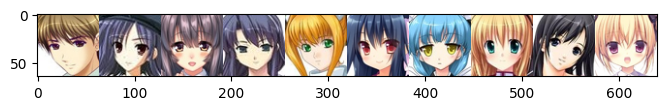

In [84]:
def gallery(array, ncols=8):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

from PIL import Image
import random
import numpy as np

display_no_images = 10
def make_array():

    arr = []
    target_size = (IMAGE_SIZE, IMAGE_SIZE)
    # Randomly select display_no_images images to visualize
    for i in range(display_no_images):
        random_image_path = random.choice(image_list)
        # Open image, convert to RGB, resize, then convert to numpy array
        img = Image.open(random_image_path).convert('RGB')
        img_resized = img.resize(target_size) # Resize the image
        arr.append(np.asarray(img_resized))
    return np.array(arr)

array = make_array()
result = gallery(array, display_no_images)
plt.figure(figsize=(8,8))
plt.imshow(result)
plt.show()

## Pre-process and Load the Data


In [85]:
df = pd.DataFrame(rows)
df.to_csv('data.csv', index=False, header = None)

In [86]:
stats = (BETA1, BETA1, BETA1), (BETA1, BETA1, BETA1)
transform = transforms.Compose([
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.Resize(IMAGE_SIZE, interpolation=2),
                                transforms.ToTensor(),
                                transforms.Normalize(*stats)])
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

class AnimeData(Dataset):
    """
    Wrap the data into a Dataset class, and then pass it to the DataLoader
    :__init__: Initialization data
    :__getitem__: support the indexing such that dataset[i] can be used to get ith sample
    :__len__: return the size of the dataset.
    """
    def __init__(self, root, transform=None):
        self.frame = pd.read_csv(root, header=None)
        self.transform = transform


    def __len__(self):
        return len(self.frame)


    def __getitem__(self, index):
        image_name = self.frame.iloc[index, 0]
        image = Image.open(image_name)
        image = self.transform(image)
        return image
trainset = AnimeData(root='./data.csv', transform=transform)
trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## Chose between GPU or CPU

In [87]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

## Define a GAN
Configure GAN:
### Discriminator


In [88]:
class Discriminator(nn.Module):
    def __init__(self,inchannels):
        super(Discriminator,self).__init__()
        """
        Initialize the Discriminator Module
        :param inchannels: The depth of the first convolutional layer
        """
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(IMAGE_SIZE),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=IMAGE_SIZE, out_channels=2*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*IMAGE_SIZE),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=2*IMAGE_SIZE, out_channels=4*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4*IMAGE_SIZE),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=4*IMAGE_SIZE, out_channels=8*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(8*IMAGE_SIZE),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Conv2d(in_channels=8*IMAGE_SIZE, out_channels=1, kernel_size=4, stride=2, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        x = self.conv_block1(x)
        return x

D=Discriminator(3).to(device)

## Generator


torch.Size([128, 3, 64, 64])


  0%|          | 0/497 [00:00<?, ?it/s]

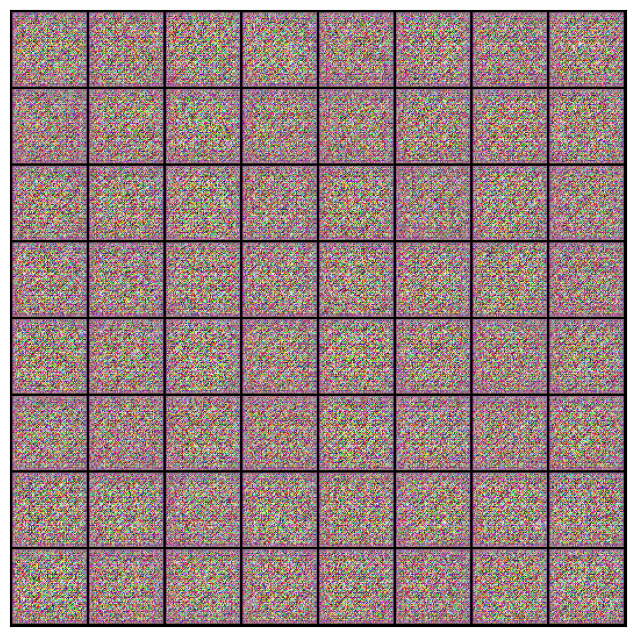

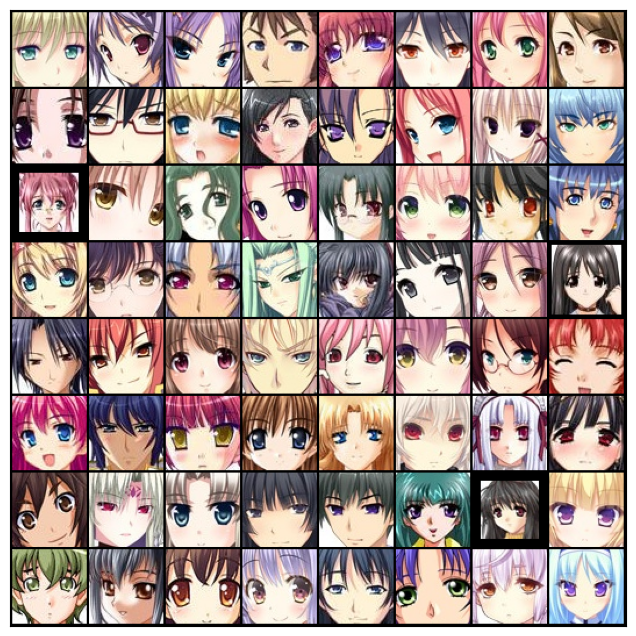

In [89]:
class Generator(nn.Module):
    def __init__(self,latent_size):
        super(Generator,self).__init__()
        """
        Initialize the Generator Module
        :param latent_size: The length of the input latent vector
        """
        self.conv_block1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=8*IMAGE_SIZE, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(8*IMAGE_SIZE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8*IMAGE_SIZE, out_channels=4*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4*IMAGE_SIZE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=4*IMAGE_SIZE, out_channels=2*IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2*IMAGE_SIZE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=2*IMAGE_SIZE, out_channels=IMAGE_SIZE, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(IMAGE_SIZE),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=IMAGE_SIZE, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self,x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: A 3x64x64 Tensor image as output
        """
        x = self.conv_block1(x)
        return x


G=Generator(LATENT_DIM).to(device)
# random latent tensors
noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1)

fake_images = G(noise)
print(fake_images.shape)

show_images(fake_images)

for real_images in tqdm(trainloader):
    real_images=(real_images).to(device)

show_images(real_images)

---
## Discriminator and Generator Losses

Calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`.
* the discriminator outputs 1 for real images and 0 for fake images

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.



In [90]:
loss_fn = torch.nn.MSELoss()
def Real_loss(preds,targets):
    '''
       Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss
    '''
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds-label_noise)
    return loss
def Fake_loss(preds,targets):
    '''
       Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss
    '''
    beta_distr = torch.distributions.beta.Beta(1,5,validate_args=None)
    label_noise = beta_distr.sample(sample_shape=targets.shape).to(torch.device(device))
    loss= loss_fn(targets,preds+label_noise)
    return loss

## Optimizers


Define optimizers models with appropriate hyperparameters.

In [91]:
# Create optimizers for the discriminator D and generator G
opt_d = optim.Adam(D.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))
opt_g = optim.Adam(G.parameters(), lr=LEARNING_RATE, betas=(BETA1, BETA2))

### Save the generated images

In [92]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, generator, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()
fixed_latent = torch.randn(IMAGE_SIZE, LATENT_DIM, 1, 1, device=device)

## Training GAN to generate anime faces
Training will involve alternating between training the discriminator and the generator. Functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.


In [93]:
# Complete the training function
losses_g = []
losses_d = []
real_scores = []
fake_scores = []
def train(D, G, d_optimizer, g_optimizer, epochs=1):
    iter_count = 0
    start_idx=1
    for epoch in range(epochs):
        for real_images in tqdm(trainloader):
            real_images=real_images.to(device)
            # Pass real images through discriminator
            D_out_real = D(real_images)
            label_real = torch.full(D_out_real.shape, 1.0).to(torch.device(device))
            real_loss = Real_loss(label_real,D_out_real)
            real_score = torch.mean(D_out_real).item()

            # Generate fake images
            noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(torch.device(device))
            fake_images =  G(noise)

            # Pass fake images through discriminator
            D_out_fake = D(fake_images)
            label_fake =  torch.full(D_out_fake.shape, 0).to(torch.device(device))
            fake_loss = Fake_loss(label_fake, D_out_fake)
            fake_score = torch.mean(D_out_fake).item()

            # Update discriminator weights
            loss_d = real_loss + fake_loss

            d_optimizer.zero_grad()
            loss_d.backward(retain_graph = True)
            d_optimizer.step()

            # Generate fake images
            noise2 = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(torch.device(device))
            fake_images2 =  G(noise2)

            gen_steps = 1
            for i in range(0, gen_steps ):
            # Try to fool the discriminator
                D_out_fake2 = D(fake_images2)

                # The label is set to 1(real-like) to fool the discriminator
                label_real1 = torch.full(D_out_fake2.shape, 1.0).to(torch.device(device))
                loss_g = Real_loss(label_real1, D_out_fake2)

                # Update generator weights
                g_optimizer.zero_grad()
                loss_g.backward(retain_graph = (i<gen_steps -1 ))
                g_optimizer.step()


        losses_g.append(loss_g.item())
        losses_d.append(loss_d.item())
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
        epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent,G, show=True)

        state_dis = {'dis_model': D.state_dict(), 'epoch': epoch}
        state_gen = {'gen_model': G.state_dict(), 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state_dis, 'checkpoint/'+'D__'+str(epoch+1)) #each epoch
        torch.save(state_gen, 'checkpoint/'+'G__'+str(epoch+1)) #each epoch
#Train the GAN
train(D,G,opt_d,opt_g,epochs=NUM_EPOCHS)

  0%|          | 0/497 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
##Visualize loss curve of D and G
fig, ax = plt.subplots()
plt.plot(losses_g, label='Discriminator', alpha=BETA1)
plt.plot(losses_d, label='Generator', alpha=BETA1)
plt.title("Training Losses")
plt.legend()

## StyleGAN

### Hyperparameters

In [94]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import save_image, make_grid
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

LATENT_DIM = 512
NUM_EPOCHS = 1
BATCH_SIZE = 32

Mapping network: Maps latent code z to intermediate latent code w

This is a key innovation in StyleGAN that enables better disentanglement

In [95]:

class MappingNetwork(nn.Module):

    def __init__(self, latent_dim=512, hidden_dim=512, num_layers=8):
        super(MappingNetwork, self).__init__()

        layers = []
        for i in range(num_layers):
            layers.extend([
                nn.Linear(latent_dim if i == 0 else hidden_dim, hidden_dim),
                nn.LeakyReLU(0.2)
            ])

        self.mapping = nn.Sequential(*layers)

    def forward(self, z):
        return self.mapping(z)

Adaptive Instance Normalization (AdaIN)
    Transfers style information from w to the feature maps

In [96]:
class AdaptiveInstanceNorm(nn.Module):

    def __init__(self, num_features, w_dim):
        super(AdaptiveInstanceNorm, self).__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)

        # Style modulation parameters
        self.style_scale = nn.Linear(w_dim, num_features)
        self.style_bias = nn.Linear(w_dim, num_features)

    def forward(self, x, w):
        # Normalize the input
        x = self.norm(x)

        # Apply style modulation
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)

        return style_scale * x + style_bias

Injects learned noise into feature maps for stochastic variation

In [97]:
class NoiseInjection(nn.Module):

    def __init__(self):
        super(NoiseInjection, self).__init__()
        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, x, noise=None):
        if noise is None:
            batch, _, height, width = x.shape
            noise = torch.randn(batch, 1, height, width, device=x.device)

        return x + self.weight * noise

StyleGAN synthesis block with AdaIN and noise injection

In [98]:
class StyleBlock(nn.Module):


    def __init__(self, in_channels, out_channels, w_dim, upsample=True):
        super(StyleBlock, self).__init__()

        self.upsample = upsample
        if upsample:
            self.upsample_layer = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.noise = NoiseInjection()
        self.adain = AdaptiveInstanceNorm(out_channels, w_dim)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x, w, noise=None):
        if self.upsample:
            x = self.upsample_layer(x)

        x = self.conv(x)
        x = self.noise(x, noise)
        x = self.adain(x, w)
        x = self.activation(x)

        return x

Generator

In [99]:
class StyleGenerator(nn.Module):
    """
    StyleGAN Generator with mapping network and synthesis network
    Generates 64x64 anime faces
    """

    def __init__(self, latent_dim=512, w_dim=512, img_channels=3):
        super(StyleGenerator, self).__init__()

        self.latent_dim = latent_dim
        self.w_dim = w_dim

        # Mapping network
        self.mapping = MappingNetwork(latent_dim, w_dim)

        # Initial constant input (learned)
        self.constant_input = nn.Parameter(torch.randn(1, 512, 4, 4))

        # Synthesis network
        self.style_blocks = nn.ModuleList([
            StyleBlock(512, 512, w_dim, upsample=False),  # 4x4
            StyleBlock(512, 512, w_dim, upsample=True),  # 8x8
            StyleBlock(512, 256, w_dim, upsample=True),  # 16x16
            StyleBlock(256, 128, w_dim, upsample=True),  # 32x32
            StyleBlock(128, 64, w_dim, upsample=True),  # 64x64
        ])

        # RGB output layers for each resolution
        self.to_rgb = nn.ModuleList([
            nn.Conv2d(512, img_channels, 1),
            nn.Conv2d(512, img_channels, 1),
            nn.Conv2d(256, img_channels, 1),
            nn.Conv2d(128, img_channels, 1),
            nn.Conv2d(64, img_channels, 1),
        ])

    def forward(self, z, return_w=False):
        batch_size = z.shape[0]

        # Map to intermediate latent space
        w = self.mapping(z)

        # Start with constant input
        x = self.constant_input.repeat(batch_size, 1, 1, 1)

        # Progressive synthesis
        for i, style_block in enumerate(self.style_blocks):
            x = style_block(x, w)

        # Convert to RGB
        img = self.to_rgb[-1](x)
        img = torch.tanh(img)

        if return_w:
            return img, w
        return img

    def style_mixing(self, z1, z2, mix_layer=2):
        """
        Style mixing: use different w vectors at different layers
        """
        batch_size = z1.shape[0]

        w1 = self.mapping(z1)
        w2 = self.mapping(z2)

        x = self.constant_input.repeat(batch_size, 1, 1, 1)

        for i, style_block in enumerate(self.style_blocks):
            w = w1 if i < mix_layer else w2
            x = style_block(x, w)

        img = self.to_rgb[-1](x)
        img = torch.tanh(img)

        return img

Discriminator

In [100]:
class StyleDiscriminator(nn.Module):
    """
    Progressive discriminator for StyleGAN
    """

    def __init__(self, img_channels=3):
        super(StyleDiscriminator, self).__init__()

        self.model = nn.Sequential(
            # 64x64 -> 32x32
            nn.Conv2d(img_channels, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            # 32x32 -> 16x16
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            # 16x16 -> 8x8
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            # 8x8 -> 4x4
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            # 4x4 -> 1x1
            nn.Conv2d(512, 1, 4, 1, 0),
        )

    def forward(self, img):
        return self.model(img).view(-1)

## Training StyleGAN

In [104]:
class AnimeFaceDataset(Dataset):
    """Dataset class for loading anime face images"""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [f for f in os.listdir(root_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image


def train_stylegan(num_epochs=200,
                   batch_size=32, latent_dim=512, lr=0.0002):

    # Initialize models
    generator = StyleGenerator(latent_dim=latent_dim).to(device)
    discriminator = StyleDiscriminator().to(device)

    start_idx=1

    # Initialize weights
    def weights_init(m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

    generator.apply(weights_init)
    discriminator.apply(weights_init)

    # Optimizers
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.99))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.0, 0.99))

    # Loss function
    criterion = nn.BCEWithLogitsLoss()

    # Fixed noise for visualization
    fixed_noise = torch.randn(64, latent_dim, device=device)

    # Training history
    g_losses = []
    d_losses = []

    print("Starting StyleGAN training...")

    for epoch in range(num_epochs):
        epoch_g_loss = 0
        epoch_d_loss = 0

        pbar = tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}')
        for i, real_imgs in enumerate(pbar):
            batch_size_curr = real_imgs.size(0)
            real_imgs = real_imgs.to(device)

            # Labels
            real_labels = torch.ones(batch_size_curr, device=device)
            fake_labels = torch.zeros(batch_size_curr, device=device)

            # ---------------------
            #  Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()

            # Real images
            real_output = discriminator(real_imgs)
            d_loss_real = criterion(real_output, real_labels)

            # Fake images
            z = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_imgs = generator(z)
            fake_output = discriminator(fake_imgs.detach())
            d_loss_fake = criterion(fake_output, fake_labels)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizer_D.step()

            # -----------------
            #  Train Generator
            # -----------------
            optimizer_G.zero_grad()

            # Generate fake images
            z = torch.randn(batch_size_curr, latent_dim, device=device)
            fake_imgs = generator(z)
            fake_output = discriminator(fake_imgs)

            # Generator loss
            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            optimizer_G.step()

            # Update progress bar
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            pbar.set_postfix({'G_loss': g_loss.item(), 'D_loss': d_loss.item()})



        # Calculate average losses
        avg_g_loss = epoch_g_loss / len(trainloader)
        avg_d_loss = epoch_d_loss / len(trainloader)
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - G_loss: {avg_g_loss:.4f}, D_loss: {avg_d_loss:.4f}")

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent,G, show=True)

        state_dis = {'discriminator_model': discriminator.state_dict(), 'epoch': epoch}
        state_gen = {'generator_model': generator.state_dict(), 'epoch': epoch}
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state_dis, 'checkpoint/'+'discriminator__'+str(epoch+1)) #each epoch
        torch.save(state_gen, 'checkpoint/'+'generator__'+str(epoch+1)) #each epoch

    # Plot training losses
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('StyleGAN Training Losses')
    plt.close()

    print("Training complete!")
    return generator, discriminator


generator, discriminator = train_stylegan(
        num_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        latent_dim=LATENT_DIM
    )

Starting StyleGAN training...


Epoch 1/1:   2%|▏         | 12/497 [08:50<5:57:13, 44.19s/it, G_loss=11.3, D_loss=3.01]


KeyboardInterrupt: 

Latent space interpolation

In [ ]:

def generate_samples(generator, num_samples=16, latent_dim=512, output_path='stylegan_samples.png'):
    """Generate samples from trained StyleGAN"""
    device = next(generator.parameters()).device
    generator.eval()

    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim, device=device)
        fake_imgs = generator(z)
        save_image(fake_imgs, output_path, nrow=4, normalize=True)

    print(f"Generated samples saved to {output_path}")


def latent_space_interpolation(generator, num_steps=10, latent_dim=512,
                               output_path='stylegan_interpolation.png'):
    """
    Create smooth interpolation between two random points in latent space
    """
    device = next(generator.parameters()).device
    generator.eval()

    with torch.no_grad():
        # Generate two random latent codes
        z1 = torch.randn(1, latent_dim, device=device)
        z2 = torch.randn(1, latent_dim, device=device)

        # Interpolate
        alphas = torch.linspace(0, 1, num_steps, device=device)
        interpolated_images = []

        for alpha in alphas:
            z = (1 - alpha) * z1 + alpha * z2
            img = generator(z)
            interpolated_images.append(img)

        # Save grid
        grid = torch.cat(interpolated_images, dim=0)
        save_image(grid, output_path, nrow=num_steps, normalize=True)

    print(f"Interpolation saved to {output_path}")


print("\nGenerating samples...")
generate_samples(generator, num_samples=16, latent_dim=LATENT_DIM,
                     output_path=f'{OUTPUT_DIR}/final_samples.png')

# Latent space interpolation
print("\nCreating latent space interpolation...")
latent_space_interpolation(generator, num_steps=10, latent_dim=LATENT_DIM,
                    output_path=f'{OUTPUT_DIR}/interpolation.png')


Comparison between both 2 models

In [ ]:
def compare_with_dcgan(stylegan_path, dcgan_path, output_dir='comparison'):
    """
    Generate samples from both models for visual comparison
    """
    os.makedirs(output_dir, exist_ok=True)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load StyleGAN
    stylegan = StyleGenerator().to(device)
    stylegan.load_state_dict(torch.load(stylegan_path, map_location=device)['generator_state_dict'])
    stylegan.eval()

    # Load DCGAN (assuming you have the DCGAN generator)
    from anime_dcgan import Generator as DCGANGenerator
    dcgan = DCGANGenerator().to(device)
    dcgan.load_state_dict(torch.load(dcgan_path, map_location=device)['generator_state_dict'])
    dcgan.eval()

    with torch.no_grad():
        # Generate samples
        z = torch.randn(16, 512, device=device)

        # StyleGAN samples
        stylegan_samples = stylegan(z)
        save_image(stylegan_samples, f'{output_dir}/stylegan_samples.png', nrow=4, normalize=True)

        # DCGAN samples (reshape z if needed)
        z_dcgan = z.unsqueeze(2).unsqueeze(3) if len(dcgan(z[:1]).shape) == 4 else z
        dcgan_samples = dcgan(z_dcgan)
        save_image(dcgan_samples, f'{output_dir}/dcgan_samples.png', nrow=4, normalize=True)

    print(f"Comparison samples saved to {output_dir}")